# Solar Sail Trajectory Optimization

## Problem Overview
The goal is to determine the optimal trajectory for a solar sail spacecraft to transfer from a Low Earth Orbit (LEO) to a Highly Elliptical Orbit (HEO) while minimizing the time required. The spacecraft is propelled by the pressure of sunlight, and the trajectory is governed by the sail orientation angle.

## States
1. **Radial Distance (\(r\))**: Distance from the Earth (arbitrary units).
2. **Radial Velocity (\(v_r\))**: Velocity in the radial direction.
3. **Tangential Velocity (\(v_t\))**: Velocity perpendicular to the radial direction.

## Controls
1. **Sail Orientation Angle (\(\alpha\))**: Determines the direction of the solar radiation force.

## Dynamics
The spacecraft motion is governed by the following equations:

\[
\dot{r} = v_r
\]

\[
\dot{v_r} = \frac{P}{r^2} \cos(\alpha) - \frac{1}{r^2} + \frac{v_t^2}{r}
\]

\[
\dot{v_t} = \frac{P}{r^2} \sin(\alpha) - \frac{v_r v_t}{r}
\]

Where:
- \(P\): Solar radiation pressure constant.
- \(\alpha\): Sail orientation angle.

## Objective
Minimize the time of flight (\(t_f\)) required for the transfer.

## Constraints
1. **Initial Conditions**:
   - \(r = r_0\), \(v_r = 0\), \(v_t = 1.0\).
2. **Final Conditions**:
   - \(r = r_f\), \(v_r = 0\), \(v_t = 0.5\).
3. **Control Bounds**:
   - \(-\pi/2 \leq \alpha \leq \pi/2\).
4. **Radial Distance Bounds**:
   - \(r_0 \leq r \leq r_f\).


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from OpenGoddard.optimize import Problem, Guess, Condition, Dynamics

In [2]:
class SolarSail:
    def __init__(self):
        self.P = 0.001  # Solar radiation pressure constant
        self.r0 = 1.0  # Initial radial distance
        self.rf = 6.0  # Final radial distance
        self.vr0 = 0.0  # Initial radial velocity
        self.vrf = 0.0  # Final radial velocity
        self.vt0 = 1.0  # Initial tangential velocity
        self.vtf = 0.5  # Final tangential velocity
        self.tf_max = 100  # Maximum allowed time

In [3]:
def dynamics(prob, obj, section):
    """
    Defines the dynamics of the solar sail problem.
    
    Parameters:
    prob (Problem): The optimization problem instance.
    obj (SolarSail): The solar sail object containing problem parameters.
    section (int): The section of the problem being considered.
    
    Returns:
    Dynamics: The dynamics of the system.
    """
    r = prob.states(0, section)  # Radial distance
    vr = prob.states(1, section)  # Radial velocity
    vt = prob.states(2, section)  # Tangential velocity
    alpha = prob.controls(0, section)  # Sail angle

    dx = Dynamics(prob, section)
    dx[0] = vr  # dr/dt = radial velocity
    dx[1] = obj.P / r**2 * np.cos(alpha) - 1 / r**2 + vt**2 / r  # dv_r/dt
    dx[2] = obj.P / r**2 * np.sin(alpha) - vr * vt / r  # dv_t/dt
    return dx()

In [4]:
def equality(prob, obj):
    """
    Defines the equality constraints for the solar sail problem.
    
    Parameters:
    prob (Problem): The optimization problem instance.
    obj (SolarSail): The solar sail object containing problem parameters.
    
    Returns:
    Condition: The equality constraints of the system.
    """
    r = prob.states_all_section(0)  # Radial distance
    vr = prob.states_all_section(1)  # Radial velocity
    vt = prob.states_all_section(2)  # Tangential velocity
    alpha = prob.controls_all_section(0)  # Sail angle

    result = Condition()

    # Initial conditions
    result.equal(r[0], obj.r0)
    result.equal(vr[0], obj.vr0)
    result.equal(vt[0], obj.vt0)

    # Final conditions
    result.equal(r[-1], obj.rf)
    result.equal(vr[-1], obj.vrf)
    result.equal(vt[-1], obj.vtf)

    return result()

In [5]:
def inequality(prob, obj):
    """
    Defines the inequality constraints for the solar sail problem.
    
    Parameters:
    prob (Problem): The optimization problem instance.
    obj (SolarSail): The solar sail object containing problem parameters.
    
    Returns:
    Condition: The inequality constraints of the system.
    """
    r = prob.states_all_section(0)  # Radial distance
    alpha = prob.controls_all_section(0)  # Sail angle
    tf = prob.time_final(-1)  # Final time

    result = Condition()

    # Bounds on r
    result.lower_bound(r, obj.r0)
    result.upper_bound(r, obj.rf)

    # Bounds on alpha
    result.lower_bound(alpha, -np.pi / 2)
    result.upper_bound(alpha, np.pi / 2)

    # Time bounds
    result.lower_bound(tf, 0.0)
    result.upper_bound(tf, obj.tf_max)

    return result()


In [6]:
def cost(prob, obj):
    """
    Defines the cost function for the solar sail problem.
    
    Parameters:
    prob (Problem): The optimization problem instance.
    obj (SolarSail): The solar sail object containing problem parameters.
    
    Returns:
    float: The cost of the system (0.0 in this case).
    """
    return 0.0  # No explicit cost

In [7]:
def running_cost(prob, obj):
    """
    Defines the running cost function for the solar sail problem.
    
    Parameters:
    prob (Problem): The optimization problem instance.
    obj (SolarSail): The solar sail object containing problem parameters.
    
    Returns:
    float: The running cost of the system (1.5 in this case).
    """
    return 1.5  # Minimize time


In [8]:
# Problem setup
time_init = [0.0, 20.0]  # Initial and final time
n = [120]  # Number of nodes
num_states = [4]  # Number of state variables
num_controls = [1]  # Number of control variables
max_iteration = 10  # Maximum number of iterations

# Initialize the problem
prob = Problem(time_init, n, num_states, num_controls, max_iteration)
obj = SolarSail()

# Initial guesses
r_guess = Guess.linear(prob.time_all_section, obj.r0, obj.rf)
vr_guess = Guess.linear(prob.time_all_section, obj.vr0, obj.vrf)
vt_guess = Guess.linear(prob.time_all_section, obj.vt0, obj.vtf)
alpha_guess = Guess.linear(prob.time_all_section, 0.0, 0.0)

# Set initial guesses for states and controls
prob.set_states_all_section(0, r_guess)
prob.set_states_all_section(1, vr_guess)
prob.set_states_all_section(2, vt_guess)
prob.set_controls_all_section(0, alpha_guess)

# Set problem dynamics and constraints
prob.dynamics = [dynamics]
prob.cost = cost
prob.running_cost = running_cost
prob.equality = equality
prob.inequality = inequality

# Solve the problem
prob.solve(obj)

# Post-process results
r = prob.states_all_section(0)  # Radial distance
vr = prob.states_all_section(1)  # Radial velocity
vt = prob.states_all_section(2)  # Tangential velocity
alpha = prob.controls_all_section(0)  # Sail angle
time = prob.time_update()  # Time

---- iteration : 1 ----
Iteration limit reached    (Exit mode 9)
            Current function value: 2.999999999999998
            Iterations: 25
            Function evaluations: 15050
            Gradient evaluations: 25
Iteration limit reached

---- iteration : 2 ----
Iteration limit reached    (Exit mode 9)
            Current function value: 2.999999999999998
            Iterations: 25
            Function evaluations: 15050
            Gradient evaluations: 25
Iteration limit reached

---- iteration : 3 ----
Iteration limit reached    (Exit mode 9)
            Current function value: 2.999999999999998
            Iterations: 25
            Function evaluations: 15050
            Gradient evaluations: 25
Iteration limit reached

---- iteration : 4 ----
Iteration limit reached    (Exit mode 9)
            Current function value: 2.999999999999998
            Iterations: 25
            Function evaluations: 15050
            Gradient evaluations: 25
Iteration limit reached

---- ite

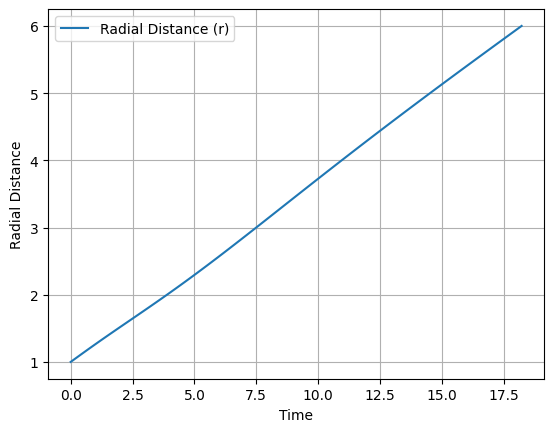

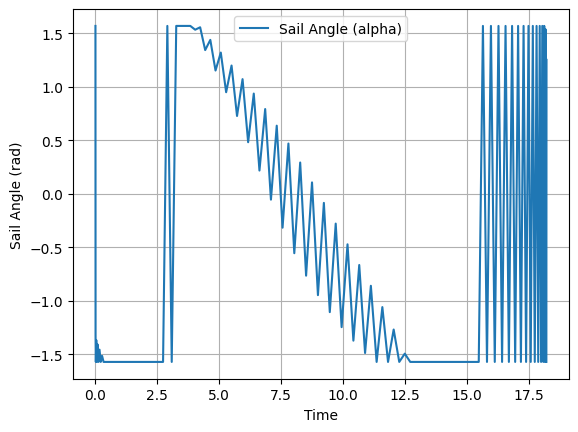

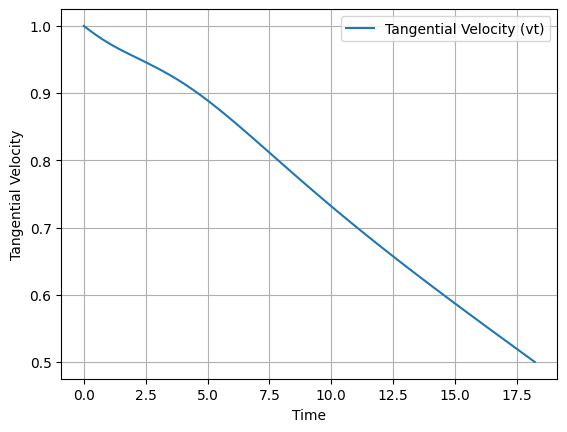

In [9]:


# Plot results
plt.figure()
plt.plot(time, r, label="Radial Distance (r)")
plt.xlabel("Time")
plt.ylabel("Radial Distance")
plt.grid()
plt.legend()

plt.figure()
plt.plot(time, alpha, label="Sail Angle (alpha)")
plt.xlabel("Time")
plt.ylabel("Sail Angle (rad)")
plt.grid()
plt.legend()

plt.figure()
plt.plot(time, vt, label="Tangential Velocity (vt)")
plt.xlabel("Time")
plt.ylabel("Tangential Velocity")
plt.grid()
plt.legend()

plt.show()
